In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Task 1

The possible states are : 

$$S = [1,2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29,30]$$   

With s = 1 being the initial state and s = 30 being the terminal state.

The action space is :

$$A =\{1, 2, 3\}$$ 
where :

1 = pay 3 points and move 1 step forward 

2 = pay 1 point and roll dice {1, 2, 3} 

3 = pay  2 point and roll  dice {4, 5, 6, 7}

$$R = \{- 8,..., -3, -1, -2,...,9\}$$ 

The lowest reward we can get is if we choose action 3 on case 29 and obtain 7, which leaves us with -2 (action cost) -6 (overshoot penalty) = -8. The best case scenario is being in case 29 and rolling the dice  {1, 2, 3}, and obtaining 1 which lands us to case 30 (+10) so the maximum reward is 10-1 = 9. 

# Task 2

The following class represents the Snakes and Ladders game as a reinforcement learning environment.
The environment supports custom snake and ladder configurations through constructor arguments,
which is useful for experiments such as Task 6.

In [2]:
class SnakesLadders():
    def __init__(self, snakes=None, ladders=None):
        "Initializes the game, with ladders, snakes and actions"

        self.snakes = snakes if snakes is not None else {17: 4, 20: 6, 24: 16}
        self.ladders = ladders if ladders is not None else {5: 7, 9: 27, 11: 29}
        self.initial_state = 1
        self.actions = {
            1: {'cost': 3, 'moves': [1]},              
            2: {'cost': 1, 'moves': [1, 2, 3]},        
            3: {'cost': 2, 'moves': [4, 5, 6, 7]}       
        }
        self.terminal_state = 30
        self.reset() # set initial state

    def reset(self):
        "Method that resets the game to the initial state (it is also called in the initialization to ensure the game starts in the initial state)"

        self.position = self.initial_state
        self.points = 0
        self.done = False       # game end flag
        return self.get_state()

    def get_state(self):
        return (self.position, self.points) if not self.done else "terminal"

    def apply_snake_or_ladder(self, pos):
        "method that determines whether the positions contains a snake or a ladder and returns the new position"

        if pos in self.snakes:  # check if the position is a snake
            return self.snakes[pos]
        elif pos in self.ladders:   # check if the position is a ladder
            return self.ladders[pos]
        return pos # return the same position if no snake or ladder

    def step(self, action):
        "Method that takes an action and returns the reward and the new state"

        if self.done:   # check if the game is over
            return 0, self.get_state()

        if action not in self.actions:  # check if the action is valid
            raise ValueError("Invalid action. Use 1, 2, or 3.")

        info = self.actions[action] # get action info
        roll = random.choice(info['moves']) # roll the dice
        cost = info['cost'] # get the cost of the action
        reward = -cost # set the reward
        new_pos = self.position + roll # calculate new position

        if new_pos > self.terminal_state:   # overshoot
            overshoot = new_pos - self.terminal_state
            reward -= overshoot
            new_pos = self.initial_state
        elif new_pos == self.terminal_state:    # reached terminal state
            reward += 10
            self.position = self.terminal_state
            self.done = True
            self.points += reward
            return reward, self.get_state()

        else:  # normal move
            new_pos = self.apply_snake_or_ladder(new_pos) # apply snake or ladder to check what happens

        self.position = new_pos # update position
        self.points += reward   # update points
        return reward, self.get_state()    # return state
    
    def get_non_special_states(self): 
        "Method that returns the states that are not snakes or ladders, i.e. the state space. It will be useful for plotting as well as for the value iteration algorithm"
        
        return [s for s in range(1, self.terminal_state + 1)
            if s not in self.snakes and s not in self.ladders]


# Task 3

- “Step”: The player always takes a single step.
- “Roll”: The player always rolls the smaller dice.
- “Random”: The player takes a single step with probability 0.5, rolls the smaller dice with probability 0.3, and rolls the larger dice with probability 0.2.

## Policy definition

We will create a helper function to build policies : 

In [3]:
def build_policy(env, action_probs):
    policy = {}
    # Non-terminal states
    for s in env.get_non_special_states():
        policy[s] = action_probs.copy()
    # Terminal state: all zero
    policy[env.terminal_state] = {a: 0.0 for a in env.actions.keys()}

    return policy

Building the policies using the function :

In [4]:
policy_step = build_policy(SnakesLadders(), {1: 1.0, 2: 0.0, 3: 0.0})
policy_roll = build_policy(SnakesLadders(), {1: 0.0, 2: 1.0, 3: 0.0})
policy_random = build_policy(SnakesLadders(), {1: 0.5, 2: 0.3, 3: 0.2})

## Definition of action evaluation and evaluation policy functions

We will create an action evaluation function that will be helpful for the policy evaluation.

In [5]:
def evalAction(s, a, V, env, gamma=1.0):
    cost = env.actions[a]['cost']
    moves = env.actions[a]['moves']
    base_reward = -cost
    q_value = 0

    for move in moves: # iterate over possible moves at the given state
        if s == env.terminal_state: # check if the state is terminal 
            break
        next_pos = s + move
        r = base_reward

        if next_pos == env.terminal_state:
            r += 10
            q_value += (1 / len(moves)) * r
            continue
        elif next_pos > env.terminal_state:
            overshoot = next_pos - env.terminal_state
            r -= overshoot
            next_state = 1
        else:
            next_state = env.apply_snake_or_ladder(next_pos)

        q_value += (1 / len(moves)) * (r + gamma * V[next_state])

    return q_value


Its output is the action-value function $$q_{\pi}(s,a) =[R_{t+1}+\gamma v_{\pi}(S_{t+1})|S_t =s, A_t = a]$$

In [6]:
def evalPolicy(env, policy, gamma=1.0, theta=1e-6):

    V = {s: 0.0 for s in env.get_non_special_states()} # initialize value function
    non_special = env.get_non_special_states()


    while True:
        delta = 0
        new_V = V.copy()

        for s in non_special:  # iterate over possible states
            v = 0
            for action, action_prob in policy[s].items():
                q = evalAction(s, action, V, env, gamma) # We use previously defined function
                v += action_prob * q
            new_V[s] = v
            delta = max(delta, abs(V[s] - v))

        V = new_V
        if delta < theta:
            break

    return V

This function outputs the state-value function as given in slide 12 of MDP lesson:  $$v(s) = E_{\pi}[R_{t+1}+\gamma v_{\pi}(S_{t+1})|S_t =s]$$

See that we have to initialize v(s)=0 for all S in order to give the evalAction function a starting point for the first iteration.

## Policy evaluation

Evaluate each policy with created function : 

In [7]:
V_steps = evalPolicy(SnakesLadders(), policy_step)
V_rolls = evalPolicy(SnakesLadders(), policy_roll)
V_random = evalPolicy(SnakesLadders(), policy_random)

In [8]:
print({k: round(v, 2) for k, v in V_steps.items()})
print({k: round(v, 2) for k, v in V_rolls.items()})
print({k: round(v, 2) for k, v in V_random.items()})

{1: -17.0, 2: -14.0, 3: -11.0, 4: -8.0, 6: -8.0, 7: -5.0, 8: -2.0, 10: 4.0, 12: -23.0, 13: -20.0, 14: -17.0, 15: -14.0, 16: -11.0, 18: -14.0, 19: -11.0, 21: -20.0, 22: -17.0, 23: -14.0, 25: -5.0, 26: -2.0, 27: 1.0, 28: 4.0, 29: 7.0, 30: 0.0}
{1: -6.86, 2: -6.36, 3: -5.72, 4: -5.5, 6: -3.83, 7: -4.84, 8: -4.44, 10: -7.88, 12: -8.91, 13: -8.49, 14: -7.74, 15: -7.49, 16: -7.23, 18: -6.73, 19: -6.47, 21: -6.91, 22: -5.67, 23: -4.82, 25: -1.95, 26: -2.27, 27: 0.8, 28: -1.37, 29: -3.24, 30: 0.0}
{1: -28.67, 2: -27.51, 3: -26.47, 4: -25.18, 6: -25.41, 7: -24.32, 8: -21.98, 10: -19.6, 12: -32.6, 13: -31.59, 14: -30.56, 15: -29.49, 16: -27.92, 18: -28.51, 19: -27.15, 21: -26.04, 22: -24.86, 23: -24.56, 25: -20.24, 26: -19.51, 27: -17.88, 28: -15.92, 29: -8.87, 30: 0.0}


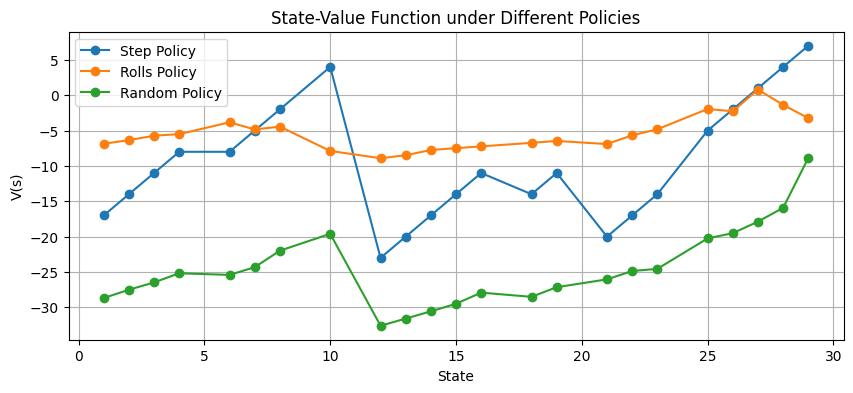

In [9]:
states = SnakesLadders().get_non_special_states()[0:-1] # remove 30 because it is the terminal state and its value is always 0
values_steps = [V_steps[s] for s in states]
values_rolls = [V_rolls[s] for s in states]
values_random = [V_random[s] for s in states]

plt.figure(figsize=(10, 4))
plt.plot(states, values_steps, label="Step Policy", marker='o')
plt.plot(states, values_rolls, label="Rolls Policy", marker = 'o')
plt.plot(states, values_random, label="Random Policy", marker = 'o')
plt.xlabel("State")
plt.ylabel("V(s)")
plt.title("State-Value Function under Different Policies")
plt.grid(True)
plt.legend()
plt.show()


The Random policy has a high probability (0.5) for the most costly action (Step: cost = –3), and lower probabilities for actions with good risk-reward trade-offs (Roll 1–3 and Roll 4–7). As a result, the agent will pay high costs without consistent progress. This leads to a relatively low return across most states. 

The Rolls policy produces a more stable and higher-valued function. It demonstrates a good balance between movement and cost. While the moves are stochastic and fairly restricted, the low cost per move allows for a steady accumulation of progress towards the terminal state, yielding moderate but consistent returns

The Step policy generates a highly variable value function. Since it always advances the player by one square at a very high cost of –3, the value of this policy is highly sensitive to the location of snakes and ladders. In those states where the player is close to stepping onto a ladder (such as position 10 that leads to 11 and thus directly to 29), there is a large increase in the value because being on position 29 puts the player close to the end game reward of +10. On the other hand, states before entering a "snake" case result in extreme value losses because falling into a snake's head makes the player go backward and lose his progress. 

v(30) is hidden from the above graphic for visibility purposes, as its value for each policy is 0. (no action can be taken at this state.)

# Task 4

We create a policy improvement function, that takes an initial value function list. It iterates through all possible states, and for each state it evaluates every possible action and sets a probability of 1 of choosing the best action at this state and 0 at the others.

In [10]:
def policyImprovement(env, V, gamma=1.0):
    policy = {}

    for s in env.get_non_special_states(): # iterate over possible states
        best_action = None # Initialize best action
        best_value = float('-inf') # Initialize best value

        for a in env.actions:
            q = evalAction(s, a, V, env, gamma) # evaluate action
            if q > best_value: # update best action and value
                best_value = q
                best_action = a

        policy[s] = {a: 1.0 if a == best_action else 0.0 for
                      a in env.actions} # update policy

    # We can also ensure that the terminal state has no action probabilities but it is not necessary as we will not use it
    # policy[env.terminal_state] = {a: 0.0 for a in env.actions

    return policy


Now that our function is set, we create a while loop that evaluates the policy before and after improvemenet. It will break once the improved policy is the same as the one without improvement.

In [11]:
policy = policy_random.copy()
while True:
    
    V = evalPolicy(SnakesLadders(), policy)
    new_policy = policyImprovement(SnakesLadders(), V)

    # Check if policy has changed
    if new_policy == policy:
        break
    policy = new_policy

policy_opt = policy
V_opt_random = evalPolicy(SnakesLadders(), policy_opt)

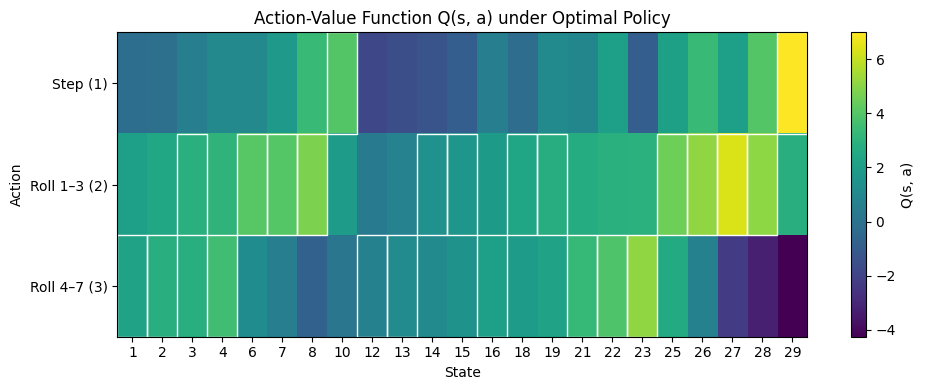

In [12]:
actions = list(SnakesLadders().actions.keys())  

Q_values = np.zeros((len(actions), len(states)))

for si, s in enumerate(states):
    for ai, a in enumerate(actions):
        Q_values[ai, si] = evalAction(s, a, V_opt_random, SnakesLadders())

plt.figure(figsize=(10, 4))
plt.imshow(Q_values, cmap='viridis', aspect='auto')
plt.colorbar(label="Q(s, a)")
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Action-Value Function Q(s, a) under Optimal Policy")
plt.xticks(ticks=np.arange(len(states)), labels=states, rotation=0)
plt.yticks(ticks=np.arange(len(actions)), labels=["Step (1)", "Roll 1–3 (2)", "Roll 4–7 (3)"])
plt.grid(False)
ax = plt.gca()

for si in range(len(states)):
    best_action_index = np.argmax(Q_values[:, si])
    rect = patches.Rectangle((si - 0.5, best_action_index - 0.5), 1, 1,
                             linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(rect)
plt.tight_layout()
plt.show()

The above plot shows the action-value Q(s,a) function under the optimal policy. Brighter colors indicate higher expected return for taking a given action in a given state. The selected action in the optimal policy is highlighted by white rectangles for illustration purposes. This policy only uses the Step action twice, at state 10 where if we get to 11, we can avoid spending anymore money to get to state 29, and at state 29 where the game ends if we step on 30. It avoids any unncessary extension of the game. 

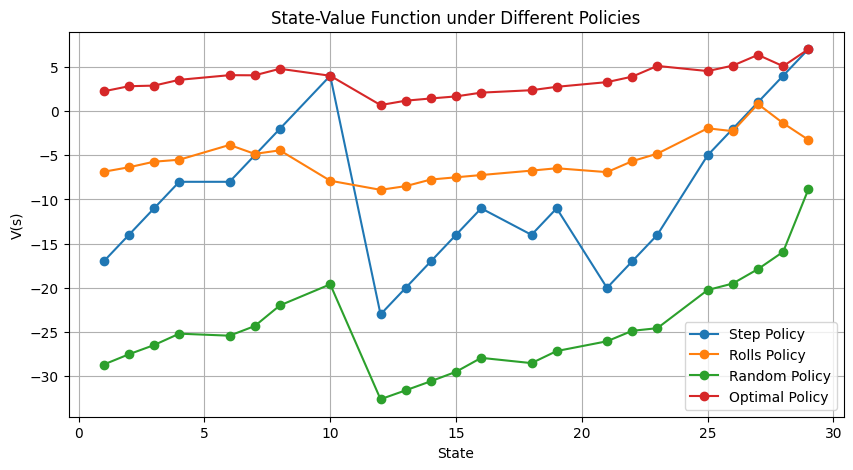

In [13]:
values_steps = [V_steps[s] for s in states]
values_rolls = [V_rolls[s] for s in states]
values_random = [V_random[s] for s in states]
values_optimal = [V_opt_random[s] for s in states]

plt.figure(figsize=(10, 5))
plt.plot(states, values_steps, label="Step Policy", marker='o')
plt.plot(states, values_rolls, label="Rolls Policy", marker='o')
plt.plot(states, values_random, label="Random Policy", marker='o')
plt.plot(states, values_optimal, label="Optimal Policy", marker='o')
plt.xlabel("State")
plt.ylabel("V(s)")
plt.title("State-Value Function under Different Policies")
plt.grid(True)
plt.legend()
plt.show()


The above plot compares V(s) under different policies. The optimal policy yields the highest expected return across nearly all states, moreover, it seems to follow the Rolls policy's fluctuations. Fixed policies (step, roll, random) are worse due to their rigid behavior. The optimal policies adapts it's actions to the board: it exploits ladders and chooses precise steps near the goal.

# Task 5

We should create a function to 

In [14]:
def monte_carlo_estimate(env_class, policy, n_episodes=1000):
    total_return = 0
    returns = []

    for episode in range(1,n_episodes + 1):
        env = env_class() # initialize class to mkae sure each game will be independant
        state = env.reset() # get initial state
        episode_return = 0

        while not env.done: #play the game one time
            pos, _ = state
            action_probs = policy[pos]  # get the action probabilities for the current state
            action = random.choices(list(action_probs.keys()), weights=action_probs.values())[0]  # choose an action
            reward, state = env.step(action) # take a step
            episode_return += reward # accumulate the reward

        total_return += episode_return
        average_return = total_return / episode
        returns.append(average_return)

    return average_return, returns  # list of running average V(s=1)


In [15]:
random.seed(123)
mc_step = monte_carlo_estimate(SnakesLadders, policy_step, n_episodes=1000)
mc_roll = monte_carlo_estimate(SnakesLadders, policy_roll, n_episodes=1000)
mc_random = monte_carlo_estimate(SnakesLadders, policy_random, n_episodes=1000)
mc_opt = monte_carlo_estimate(SnakesLadders, policy_opt, n_episodes=1000)

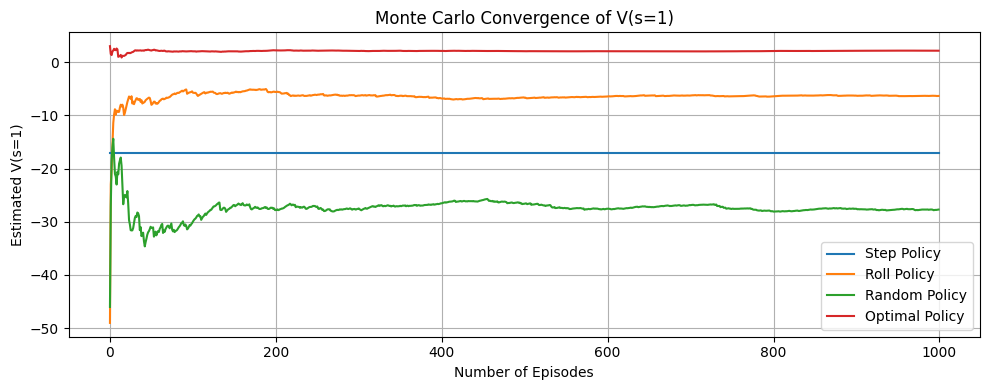

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(mc_step[1], label='Step Policy')
plt.plot(mc_roll[1], label='Roll Policy')
plt.plot(mc_random[1], label='Random Policy')
plt.plot(mc_opt[1], label='Optimal Policy')
plt.xlabel("Number of Episodes")
plt.ylabel("Estimated V(s=1)")
plt.title("Monte Carlo Convergence of V(s=1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The Monte Carlo estimate for the Step policy is stable as it is a deterministic policy. The other are stochastic so their estimated return (value of v(1)) takes more episodes to stabilize.

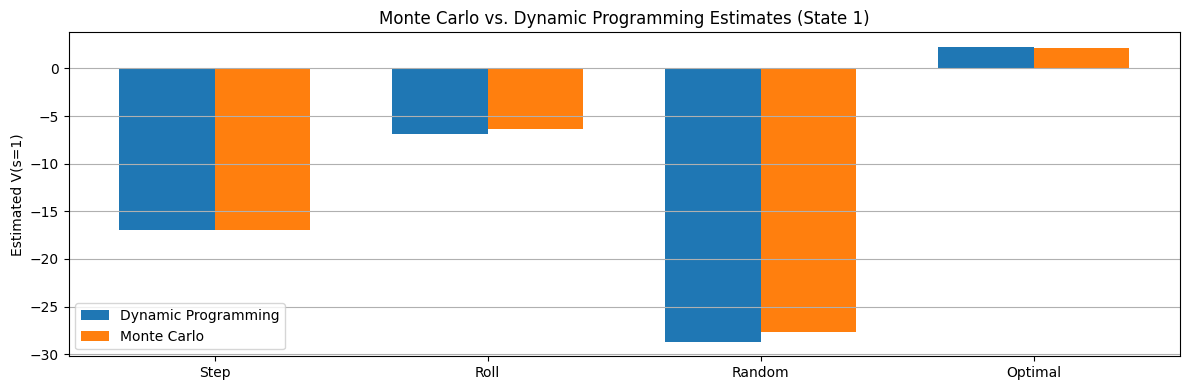

Monte Carlo Estimates for Step policy: -17.0 Dynamic Programming Estimate for Step policy: -17.0
Monte Carlo Estimates for Roll policy: -6.352 Dynamic Programming Estimate for Roll policy: -6.861
Monte Carlo Estimates for Random policy: -27.704 Dynamic Programming Estimate for Random policy: -28.674
Monte Carlo Estimates for Optimal policy: 2.147 Dynamic Programming Estimate for Optimal policy: 2.237


In [17]:
policies = ['Step', 'Roll', 'Random', 'Optimal']
mc_values = [mc_step[0], mc_roll[0], mc_random[0], mc_opt[0]]
dp_values = [V_steps[1], V_rolls[1], V_random[1], V_opt_random[1]]

x = range(len(policies))
width = 0.35

plt.figure(figsize=(12,4))
plt.bar(x, dp_values, width=width, label='Dynamic Programming')
plt.bar([i + width for i in x], mc_values, width=width, label='Monte Carlo')
plt.xticks([i + width / 2 for i in x], policies)
plt.ylabel("Estimated V(s=1)")
plt.title("Monte Carlo vs. Dynamic Programming Estimates (State 1)")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

print("Monte Carlo Estimates for Step policy:", mc_step[0], "Dynamic Programming Estimate for Step policy:", round(V_steps[1],3))
print("Monte Carlo Estimates for Roll policy:", mc_roll[0], "Dynamic Programming Estimate for Roll policy:", round(V_rolls[1],3))
print("Monte Carlo Estimates for Random policy:", mc_random[0], "Dynamic Programming Estimate for Random policy:", round(V_random[1],3))
print("Monte Carlo Estimates for Optimal policy:", mc_opt[0], "Dynamic Programming Estimate for Optimal policy:", round(V_opt_random[1],3))

The Monte Carlo simulation gives approximately the same results as the ones obtained with DP. As the Step policy is a determinisitic policy, the estimated value is the same as the one computed. The other policies still contain randomness so the estimated value will vary throughout the game played.

# Task 6 (Bonus!)

## Adding the snake

The issue that arrises with the "Step" policy is that it becomes infinite. It will always pass by the case 28 and thus go back to the 14th position which becomes an infinite loop. To avoid this situation, we will set the parameter gamma (discounting factor) define in the evaluation policy function to 0.95.

To evaluate the policies, we need to create new ones with the new SnakesLadder setting. 

In [18]:
policy_steps2 = build_policy(SnakesLadders(snakes = {17: 4, 20: 6, 24: 16, 28: 14}), {1: 1.0, 2: 0.0, 3: 0.0})
policy_rolls2 = build_policy(SnakesLadders(snakes = {17: 4, 20: 6, 24: 16, 28: 14}), {1: 0.0, 2: 1.0, 3: 0.0})
policy_random2 = build_policy(SnakesLadders(snakes = {17: 4, 20: 6, 24: 16, 28: 14}), {1: 0.5, 2: 0.3, 3: 0.2})

Then we evaluate the new policies :

In [19]:
V_steps2 = evalPolicy(SnakesLadders(snakes = {17: 4, 20: 6, 24: 16, 28: 14}), policy_steps2, gamma=0.95)
V_rolls2 = evalPolicy(SnakesLadders(snakes = {17: 4, 20: 6, 24: 16, 28: 14}), policy_rolls2)
V_random2 = evalPolicy(SnakesLadders(snakes = {17: 4, 20: 6, 24: 16, 28: 14}), policy_random2)

In [20]:
print({k: round(v, 2) for k, v in V_steps2.items()})
print({k: round(v, 2) for k, v in V_rolls2.items()})
print({k: round(v, 2) for k, v in V_random2.items()})

{1: -60.0, 2: -60.0, 3: -60.0, 4: -60.0, 6: -60.0, 7: -60.0, 8: -60.0, 10: 3.65, 12: -60.0, 13: -60.0, 14: -60.0, 15: -60.0, 16: -60.0, 18: -60.0, 19: -60.0, 21: -60.0, 22: -60.0, 23: -60.0, 25: -60.0, 26: -60.0, 27: -60.0, 29: 7.0, 30: 0.0}
{1: -10.96, 2: -10.45, 3: -9.82, 4: -9.6, 6: -7.95, 7: -8.92, 8: -8.19, 10: -11.85, 12: -13.48, 13: -13.11, 14: -12.23, 15: -12.1, 16: -12.0, 18: -11.7, 19: -11.68, 21: -12.48, 22: -11.63, 23: -10.8, 25: -9.09, 26: -8.31, 27: -3.73, 29: -5.97, 30: 0.0}
{1: -48.74, 2: -47.64, 3: -46.15, 4: -44.65, 6: -45.25, 7: -44.45, 8: -43.46, 10: -32.39, 12: -52.63, 13: -51.62, 14: -50.62, 15: -49.52, 16: -47.77, 18: -48.98, 19: -47.49, 21: -47.63, 22: -45.48, 23: -44.36, 25: -42.28, 26: -42.17, 27: -43.51, 29: -16.9, 30: 0.0}


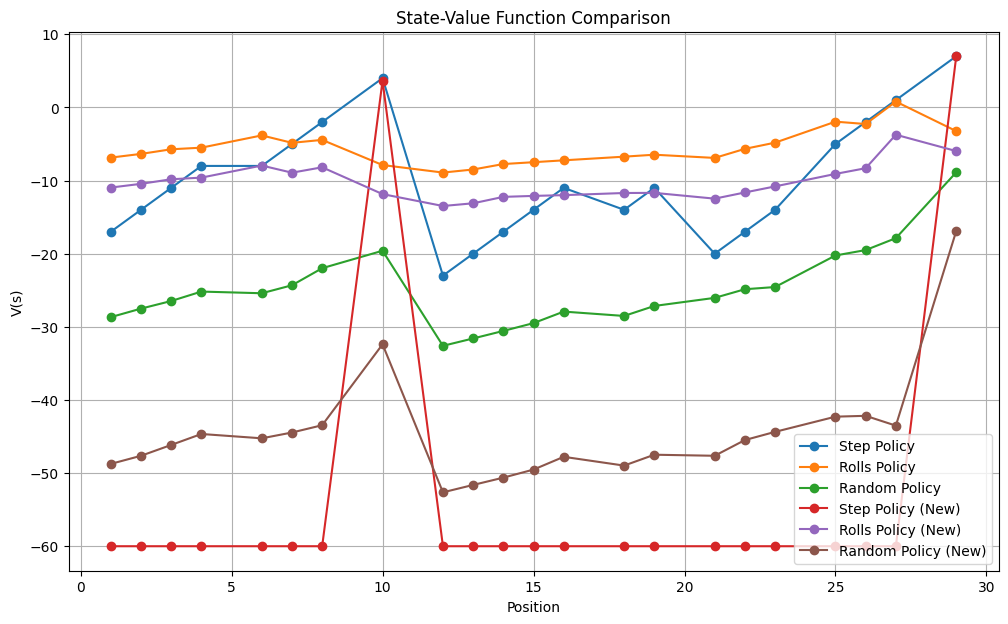

In [21]:
states = SnakesLadders(snakes = {17: 4, 20: 6, 24: 16, 28: 14}).get_non_special_states()[0:-1] # remove 30 because it is the terminal state and its value is always 0
plt.figure(figsize=(12, 7))
plt.plot(states, [V_steps[s] for s in states], label="Step Policy", marker='o')
plt.plot(states, [V_rolls[s] for s in states], label="Rolls Policy", marker='o')
plt.plot(states, [V_random[s] for s in states], label="Random Policy", marker='o')
plt.plot(states, [V_steps2[s] for s in states], label="Step Policy (New)", marker='o')
plt.plot(states, [V_rolls2[s] for s in states], label="Rolls Policy (New)", marker='o')
plt.plot(states, [V_random2[s] for s in states], label="Random Policy (New)", marker='o')
plt.xlabel("Position")
plt.grid(True)
plt.ylabel("V(s)")
plt.legend()
plt.title("State-Value Function Comparison")
plt.show()

All policies perform worse in the new board due to the added snake. 

The Step policy's value function depends on the parameter gamma. We can see from the graphic than only the case 10 and 29 have positive values due to the fact that if we reach this state, we will be able to finish the game. Their values are the same as the one from the orignial board setting. The closer the gamma parameter is to 1, the lower the values the other states will be. 

It was not necessary to introduce a gamma parameter lower than one for the other policies as they don't produce an infinite loop due to their randomness.

## Monte Carlo estimation with new snakes

To provide a MonteCarlo estimation, we need to modify our initial function so that it includes a maximum amount of step we can make before finishing the game to avoid falling in a infinite loop. 

In [22]:
def monte_carlo_estimate2(env_class, policy, n_episodes=1000, max_steps=500):
    total_return = 0
    returns = []

    for episode in range(1,n_episodes + 1):
        env = env_class(snakes = {17: 4, 20: 6, 24: 16, 28: 14}) # initinalie class with new snake
        state = env.reset() # get initial state
        episode_return = 0
        step = 0
        
        while not env.done and step < max_steps: #play the game
            step += 1 
            pos, _ = state
            action_probs = policy[pos]  # get the action probabilities for the current state
            action = random.choices(list(action_probs.keys()), weights=action_probs.values())[0]  # choose an action
            reward, state = env.step(action) # take a step
            episode_return += reward # accumulate the reward

        total_return += episode_return
        average_return = total_return / episode
        returns.append(average_return)

    return average_return, returns  # list of running average V(s=1)


In [23]:
mc_step2 = monte_carlo_estimate2(SnakesLadders, policy_steps2)
mc_roll2 = monte_carlo_estimate2(SnakesLadders, policy_rolls2)
mc_random2 = monte_carlo_estimate2(SnakesLadders, policy_random2)

In [24]:
print("Monte Carlo Estimates for Step policy:", mc_step2[0], ", Dynamic Programming Estimate for Step policy:", round(V_steps2[1],3))
print("Monte Carlo Estimates for Roll policy:", mc_roll2[0], ", Dynamic Programming Estimate for Roll policy:", round(V_rolls2[1],3))
print("Monte Carlo Estimates for Random policy:", mc_random2[0], ", Dynamic Programming Estimate for Random policy:", round(V_random2[1],3))

Monte Carlo Estimates for Step policy: -1500.0 , Dynamic Programming Estimate for Step policy: -60.0
Monte Carlo Estimates for Roll policy: -10.642 , Dynamic Programming Estimate for Roll policy: -10.958
Monte Carlo Estimates for Random policy: -48.875 , Dynamic Programming Estimate for Random policy: -48.742


The estimates for both Roll and Random policy are approximately equal, due to large number of episodes played.

In [25]:
mc_step3 = monte_carlo_estimate2(SnakesLadders, policy_steps2, max_steps = 100)
print("Monte Carlo Estimates for Step policy:", mc_step3[0], ", Dynamic Programming Estimate for Step policy:", round(V_steps2[1],3))

Monte Carlo Estimates for Step policy: -300.0 , Dynamic Programming Estimate for Step policy: -60.0


The MC estimates for Step policy depends on the number of steps we allow in our function. It will keep summing every step taken until it reaches the maximal number of steps. The lower the maximum number of steps allowed, the bigger our value v(1) will be.

# Declaration of Generative AI Tool Usage

ChatGPT (OpenAI, GPT-4) was used as a generative AI tool to support the development of this assignment.

ChatGPT was asked for assistance in order to draft functions for policy evaluation, action evaluation, and policy improvement.

All implementation, testing, and interpretation were conducted by me. I wrote the final code and results analysis, and structured the notebook. 